# HW5

Yu-Kai "Steven" Wang

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms
import numpy as np
from tqdm import tqdm
import pickle
from matplotlib import pyplot as plt

## Task 1: CNN

I will be using the CIFAR-10 dataset, downloaded from [here](https://www.cs.toronto.edu/~kriz/cifar.html). This dataset includes 60,000 32x32 colored images of 10 different labels.

### Part 1: Vanilla CNN

**Load Dataset**

Preprocess image via normalization.

In [54]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
])

Dataset implementation

In [55]:
class CIFAR_10(Dataset):
    '''
    CIFAR 10 dataset
    '''
    def __init__(self, filenames, tsfm):
        self.filenames = filenames
        self.tsfm = tsfm
        # define PIL tranformation
        self.toPIL = transforms.ToPILImage()
        # read in dataset
        self.data = []
        self.labels = []
        for filename in self.filenames:
            raw = self.unpickle(filename)
            self.data.extend(raw[b'data'])
            self.labels.extend(raw[b'labels'])
        # convert image to numpy array
        self.data = torch.from_numpy(np.array(self.data).reshape(-1, 3, 32, 32))
        # convert tensor to PIL and apply transformation for easy pre-processing
        print(f'pre-processing data...')
        self.data = [self.tsfm(self.toPIL(tensor)) for tensor in tqdm(self.data)]
        # conver labels into torch tensors
        self.labels = torch.tensor(self.labels, dtype=torch.uint8)
    
    def unpickle(self, file):
        with open(file, 'rb') as fo:
            data = pickle.load(fo, encoding='bytes')
        return data

    def __len__(self):
        return self.labels.shape[0]
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

Load train / valid / test dataset

In [56]:
train_dataset = CIFAR_10([f'../data/CIFAR_10/cifar-10-batches-py/data_batch_{i}' for i in range(1, 5)], tsfm = preprocess)
valid_dataset = CIFAR_10(['../data/CIFAR_10/cifar-10-batches-py/data_batch_5'], tsfm = preprocess)
test_dataset = CIFAR_10(['../data/CIFAR_10/cifar-10-batches-py/test_batch'], tsfm = preprocess)

pre-processing data...


100%|██████████████████████████████████████████████████████████████████████████| 40000/40000 [00:06<00:00, 6132.57it/s]


pre-processing data...


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 6082.73it/s]


pre-processing data...


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4953.70it/s]


Load label names

In [57]:
meta = None
with open('../data/CIFAR_10/cifar-10-batches-py/batches.meta', 'rb') as fo:
    meta = pickle.load(fo, encoding='bytes')

Sample image

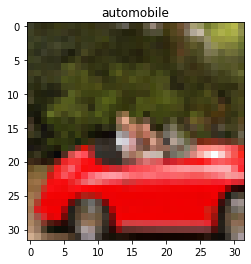

In [58]:
img, lbl = train_dataset.__getitem__(99)
plt.imshow(torch.moveaxis(img, 0, -1))
plt.title(meta[b'label_names'][lbl].decode('utf-8'))
plt.show()

**Model**

In [59]:
class SimpleCNN(nn.Module):
    def __init__(self, h1_size = 128, h2_size = 64):
        '''
        Simple CNN with 3 layers of CNN followed by 3 linear layers
        '''
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 4)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 12, 4)
        self.flatten = nn.Flatten()
        self.f1 = nn.Linear(12 * 11 * 11, h1_size)
        self.f2 = nn.Linear(h1_size, h2_size)
        self.drop1 = nn.Dropout()
        self.f3 = nn.Linear(h2_size, 10)
    
    def forward(self, x):
        # CNN and Pooling
        x = self.conv1(x)
        # print(f'conv1: {x.shape}')
        x = self.pool1(x)
        # print(f'pool1: {x.shape}')
        x = self.conv2(x)
        # print(f'conv2: {x.shape}')
        x = self.flatten(x)
        
        # drop out layer
        x = self.drop1(x)
        
        # dense layers
        x = F.relu(self.f1(x))
        x = F.relu(self.f2(x))
        x = self.f3(x)
        
        return x

**Training**

Hyper parameters

In [60]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

batch_size = 128
epochs = 30
learning_rate = 0.001

model = SimpleCNN(h1_size = 128, h2_size = 64)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

model.to(device)
model.train()

cuda:0


SimpleCNN(
  (conv1): Conv2d(3, 6, kernel_size=(4, 4), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 12, kernel_size=(4, 4), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (f1): Linear(in_features=1452, out_features=128, bias=True)
  (f2): Linear(in_features=128, out_features=64, bias=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (f3): Linear(in_features=64, out_features=10, bias=True)
)

Dataloaders

In [61]:
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size)
valid_loader = DataLoader(dataset = valid_dataset, batch_size = batch_size)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size)

Training loop

In [62]:
for epoch in range(epochs):
    sum_loss = 0
    for (data, labels) in tqdm(train_loader):
        
        # zero out gradient
        optimizer.zero_grad()
        
        # send batch to device
        data, labels = data.to(device), labels.to(device)
    
        # foward pass
        pred = model(data)
        
        # cross entropy loss
        loss = F.cross_entropy(pred, labels)
        
        # back propagation
        loss.backward()
        sum_loss += loss.item()
        optimizer.step()
    
    # print out epoch stats
    print(f'Epoch {epoch}, train loss: {sum_loss / batch_size}')

100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 196.40it/s]


Epoch 0, train loss: 4.476850221864879


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 224.86it/s]


Epoch 1, train loss: 3.796534654684365


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 216.91it/s]


Epoch 2, train loss: 3.5300636999309063


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 207.42it/s]


Epoch 3, train loss: 3.363847074098885


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 215.71it/s]


Epoch 4, train loss: 3.238971241749823


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 216.53it/s]


Epoch 5, train loss: 3.115632372908294


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 224.85it/s]


Epoch 6, train loss: 3.040105906780809


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 226.16it/s]


Epoch 7, train loss: 2.94607250764966


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 209.14it/s]


Epoch 8, train loss: 2.8806099980138242


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 208.67it/s]


Epoch 9, train loss: 2.8074221503920853


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 224.40it/s]


Epoch 10, train loss: 2.7250398523174226


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 207.72it/s]


Epoch 11, train loss: 2.6693735592998564


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 209.36it/s]


Epoch 12, train loss: 2.5914126676507294


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 210.21it/s]


Epoch 13, train loss: 2.548170919995755


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 213.94it/s]


Epoch 14, train loss: 2.5128901777788997


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 212.78it/s]


Epoch 15, train loss: 2.4549000840634108


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 219.99it/s]


Epoch 16, train loss: 2.3974605523981154


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 222.62it/s]


Epoch 17, train loss: 2.379918801598251


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 220.73it/s]


Epoch 18, train loss: 2.321195770520717


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 220.85it/s]


Epoch 19, train loss: 2.2932219090871513


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 220.11it/s]


Epoch 20, train loss: 2.2714200001209974


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 218.12it/s]


Epoch 21, train loss: 2.234493509400636


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 224.12it/s]


Epoch 22, train loss: 2.2148517901077867


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 225.29it/s]


Epoch 23, train loss: 2.180777298286557


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 223.03it/s]


Epoch 24, train loss: 2.149256225209683


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 223.64it/s]


Epoch 25, train loss: 2.1250343224965036


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 218.63it/s]


Epoch 26, train loss: 2.088302323129028


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 219.46it/s]


Epoch 27, train loss: 2.0636773724108934


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 218.37it/s]


Epoch 28, train loss: 2.0595262674614787


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 207.23it/s]

Epoch 29, train loss: 2.028358603361994


Training Accuracy

In [63]:
model.eval()
with torch.no_grad():
    correct = 0
    for (data, labels) in tqdm(train_loader):

        # send batch to device
        data, labels = data.to(device), labels.to(device)

        # foward pass
        pred = model(data.view(labels.shape[0], 3, 32, 32).float())

        # softmax and argmax
        pred = F.softmax(pred, dim = 1)
        pred = torch.argmax(pred, dim = 1)

        # compute accuracy
        correct += torch.sum(pred == labels.float())

# accuracy
print(f'Training Accuracy: {correct / len(train_dataset):.3f}')

100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 491.84it/s]

Training Accuracy: 0.782


**Validation**

In [64]:
model.eval()
with torch.no_grad():
    correct = 0
    for (data, labels) in tqdm(valid_loader):

        # send batch to device
        data, labels = data.to(device), labels.to(device)

        # foward pass
        pred = model(data.view(labels.shape[0], 3, 32, 32).float())

        # softmax and argmax
        pred = F.softmax(pred, dim = 1)
        pred = torch.argmax(pred, dim = 1)

        # compute accuracy
        correct += torch.sum(pred == labels.float())

# accuracy
print(f'Validation Accuracy: {correct / len(valid_dataset):.3f}')

100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 505.50it/s]

Validation Accuracy: 0.635


**Testing**

In [65]:
model.eval()
with torch.no_grad():
    correct = 0
    for (data, labels) in tqdm(test_loader):

        # send batch to device
        data, labels = data.to(device), labels.to(device)

        # foward pass
        pred = model(data.view(labels.shape[0], 3, 32, 32).float())

        # softmax and argmax
        pred = F.softmax(pred, dim = 1)
        pred = torch.argmax(pred, dim = 1)

        # compute accuracy
        correct += torch.sum(pred == labels.float())

# accuracy
print(f'Testing Accuracy: {correct / len(test_dataset):.3f}')

100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 506.42it/s]

Testing Accuracy: 0.616


### Part 2: Transfer Learning

In [74]:
from torchvision.models import resnet50, ResNet50_Weights, mobilenet_v2, MobileNet_V2_Weights

**Dataset**

Reload dataset to apply transformations defined by the pre-trained weights.

In [75]:
# preprocess = ResNet50_Weights.IMAGENET1K_V1.transforms()
preprocess = MobileNet_V2_Weights.IMAGENET1K_V1.transforms()

In [68]:
train_dataset = CIFAR_10([f'../data/CIFAR_10/cifar-10-batches-py/data_batch_{i}' for i in range(1, 5)], preprocess)
valid_dataset = CIFAR_10(['../data/CIFAR_10/cifar-10-batches-py/data_batch_5'], preprocess)
test_dataset = CIFAR_10(['../data/CIFAR_10/cifar-10-batches-py/test_batch'], preprocess)

pre-processing data...


100%|███████████████████████████████████████████████████████████████████████████| 40000/40000 [01:16<00:00, 525.76it/s]


pre-processing data...


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 353.61it/s]


pre-processing data...


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 303.79it/s]


**Model**

Transfer weights from ResNet50. The weights of this transfered model will be frozen (weights will not be updated) to accelerate the training.

In [85]:
model_pretrained = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
for param in model_pretrained.parameters():
    param.requires_grad = False
model_pretrained_output = model_pretrained.last_channel
model_pretrained.classifier = nn.Dropout(p = 0.2)

# spawn pre-trained model
model_pretrained.to(device)
model_pretrained.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

Dense layer implementation. This is the only layers that will be trained.

In [86]:
class ResNet50CNN(nn.Module):
    def __init__(self, output_size, h1_size = 128, h2_size = 64):
        '''
        Simple CNN with 3 layers of CNN followed by 3 linear layers
        '''
        super().__init__()
        self.f1 = nn.Linear(output_size, h1_size)
        self.f2 = nn.Linear(h1_size, h2_size)
        self.f3 = nn.Linear(h2_size, 10)
    
    def forward(self, x):        
        x = F.relu(self.f1(x))
        x = F.relu(self.f2(x))
        x = self.f3(x)

        return x

**Training**

Hyper-parameters

In [89]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

batch_size = 128
epochs = 15
learning_rate = 0.001

model = ResNet50CNN(model_pretrained_output, h1_size = 128, h2_size = 64)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

model.to(device)
model.train()

cuda:0


ResNet50CNN(
  (f1): Linear(in_features=1280, out_features=128, bias=True)
  (f2): Linear(in_features=128, out_features=64, bias=True)
  (f3): Linear(in_features=64, out_features=10, bias=True)
)

Dataloaders

In [90]:
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size)
valid_loader = DataLoader(dataset = valid_dataset, batch_size = batch_size)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size)

Training loop

In [91]:
for epoch in range(epochs):
    sum_loss = 0
    for (data, labels) in tqdm(train_loader):
        
        # zero out gradient
        optimizer.zero_grad()
        
        # send batch to device
        data, labels = data.to(device), labels.to(device)
    
        # foward pass
        data = model_pretrained(data) # pass through pre-trained CNN (ResNet50)
        pred = model(data) # self-defined dense layer
        
        # cross entropy loss
        loss = F.cross_entropy(pred, labels)
        
        # back propagation
        loss.backward()
        sum_loss += loss.item()
        optimizer.step()
    
    # print out epoch stats
    print(f'Epoch {epoch}, train loss: {sum_loss / batch_size}')

100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [01:09<00:00,  4.51it/s]


Epoch 0, train loss: 1.4926829079631716


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [01:09<00:00,  4.49it/s]


Epoch 1, train loss: 0.9867422706447542


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [01:09<00:00,  4.48it/s]


Epoch 2, train loss: 0.9007193867582828


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [01:09<00:00,  4.48it/s]


Epoch 3, train loss: 0.8425786680309102


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [01:09<00:00,  4.48it/s]


Epoch 4, train loss: 0.7929381754947826


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [01:10<00:00,  4.43it/s]


Epoch 5, train loss: 0.7474980169790797


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [01:09<00:00,  4.49it/s]


Epoch 6, train loss: 0.704665573197417


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [01:09<00:00,  4.49it/s]


Epoch 7, train loss: 0.6625836998573504


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [01:09<00:00,  4.49it/s]


Epoch 8, train loss: 0.6210005623870529


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [01:10<00:00,  4.47it/s]


Epoch 9, train loss: 0.5810100915259682


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [01:09<00:00,  4.49it/s]


Epoch 10, train loss: 0.541797828336712


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [01:09<00:00,  4.49it/s]


Epoch 11, train loss: 0.5061016182880849


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [01:09<00:00,  4.48it/s]


Epoch 12, train loss: 0.47479137690970674


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [01:09<00:00,  4.47it/s]


Epoch 13, train loss: 0.45475347444880754


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [01:10<00:00,  4.46it/s]

Epoch 14, train loss: 0.44768906355602667


Training Accuracy

In [95]:
model.eval()
with torch.no_grad():
    correct = 0
    for (data, labels) in tqdm(train_loader):

        # send batch to device
        data, labels = data.to(device), labels.to(device)

        # foward pass
        data = model_pretrained(data)
        pred = model(data)
        
        # softmax and argmax
        pred = F.softmax(pred, dim = 1)
        pred = torch.argmax(pred, dim = 1)

        # compute accuracy
        correct += torch.sum(pred == labels.float())

# accuracy
print(f'Training Accuracy: {correct / len(train_dataset):.3f}')

100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [01:07<00:00,  4.63it/s]

Training Accuracy: 0.909


**Validation**

In [96]:
model.eval()
with torch.no_grad():
    correct = 0
    for (data, labels) in tqdm(valid_loader):

        # send batch to device
        data, labels = data.to(device), labels.to(device)

        # foward pass
        data = model_pretrained(data)
        pred = model(data)
        
        # softmax and argmax
        pred = F.softmax(pred, dim = 1)
        pred = torch.argmax(pred, dim = 1)

        # compute accuracy
        correct += torch.sum(pred == labels.float())

# accuracy
print(f'Validation Accuracy: {correct / len(valid_dataset):.3f}')

100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:23<00:00,  3.33it/s]

Validation Accuracy: 0.852


**Testing**

In [97]:
model.eval()
with torch.no_grad():
    correct = 0
    for (data, labels) in tqdm(test_loader):

        # send batch to device
        data, labels = data.to(device), labels.to(device)

        # foward pass
        data = model_pretrained(data)
        pred = model(data)
        
        # softmax and argmax
        pred = F.softmax(pred, dim = 1)
        pred = torch.argmax(pred, dim = 1)

        # compute accuracy
        correct += torch.sum(pred == labels.float())

# accuracy
print(f'Testing Accuracy: {correct / len(test_dataset):.3f}')

100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:25<00:00,  3.11it/s]

Testing Accuracy: 0.845


**Transfer learning results**

As we can see, the testing accuracy using the pre-trained MobileNetV2 is significantly higher than the regular CNN I have trained (0.845 vs 0.616). By using a pre-trained model architecture that was previously trained and fine-tuned on a larger and diverse dataset, the CNN layers of the transferred model is able to better extract useful information to pass down to the dense layers, thus resulting in a huge increase in accuracy.

### Part 3: Data Augmentation

**Dataset**

Data augmentation by the following methods:
- random horizontal flip

In [246]:
preprocess_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(p = 0.5),
])
preprocess = transforms.Compose([
    transforms.ToTensor(),
])

Reload datasets

In [247]:
train_dataset = CIFAR_10([f'../data/CIFAR_10/cifar-10-batches-py/data_batch_{i}' for i in range(1, 5)], tsfm = preprocess)
valid_dataset = CIFAR_10(['../data/CIFAR_10/cifar-10-batches-py/data_batch_5'], tsfm = preprocess)
test_dataset = CIFAR_10(['../data/CIFAR_10/cifar-10-batches-py/test_batch'], tsfm = preprocess)

pre-processing data...


100%|██████████████████████████████████████████████████████████████████████████| 40000/40000 [00:07<00:00, 5245.22it/s]


pre-processing data...


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4617.87it/s]


pre-processing data...


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 3835.70it/s]


**Training**

Hyper-parameters

In [261]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

batch_size = 128
epochs = 60
learning_rate = 0.001

model = SimpleCNN(h1_size = 128, h2_size = 64)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

model.to(device)
model.train()

cuda:0


SimpleCNN(
  (conv1): Conv2d(3, 6, kernel_size=(4, 4), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 12, kernel_size=(4, 4), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (f1): Linear(in_features=1452, out_features=128, bias=True)
  (f2): Linear(in_features=128, out_features=64, bias=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (f3): Linear(in_features=64, out_features=10, bias=True)
)

Dataloaders

In [262]:
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size)
valid_loader = DataLoader(dataset = valid_dataset, batch_size = batch_size)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size)

Training loop

In [263]:
for epoch in range(epochs):
    sum_loss = 0
    for (data, labels) in tqdm(train_loader):
        
        # zero out gradient
        optimizer.zero_grad()
        
        # send batch to device
        data, labels = data.to(device), labels.to(device)
        
        # apply data augmentation
        data = preprocess_aug(data)
    
        # foward pass
        pred = model(data)
        
        # cross entropy loss
        loss = F.cross_entropy(pred, labels)
        
        # back propagation
        loss.backward()
        sum_loss += loss.item()
        optimizer.step()
    
    # print out epoch stats
    print(f'Epoch {epoch}, train loss: {sum_loss / batch_size}')

100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 181.71it/s]


Epoch 0, train loss: 4.669489562511444


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 185.63it/s]


Epoch 1, train loss: 3.8876836877316236


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 177.04it/s]


Epoch 2, train loss: 3.5897903433069587


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 185.98it/s]


Epoch 3, train loss: 3.412720932625234


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 185.43it/s]


Epoch 4, train loss: 3.2527652960270643


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 181.86it/s]


Epoch 5, train loss: 3.1557376328855753


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 180.69it/s]


Epoch 6, train loss: 3.0635639438405633


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 164.91it/s]


Epoch 7, train loss: 2.9727178825996816


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 162.12it/s]


Epoch 8, train loss: 2.8921837620437145


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 170.02it/s]


Epoch 9, train loss: 2.8289889846928418


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 180.45it/s]


Epoch 10, train loss: 2.781394853256643


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 175.97it/s]


Epoch 11, train loss: 2.7406409019604325


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 180.28it/s]


Epoch 12, train loss: 2.688627651426941


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 178.31it/s]


Epoch 13, train loss: 2.6382387951016426


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 188.80it/s]


Epoch 14, train loss: 2.614916985388845


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 190.62it/s]


Epoch 15, train loss: 2.5613553542643785


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 184.99it/s]


Epoch 16, train loss: 2.546378127299249


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 187.31it/s]


Epoch 17, train loss: 2.5143954288214445


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 185.76it/s]


Epoch 18, train loss: 2.4836866543628275


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 179.37it/s]


Epoch 19, train loss: 2.4656760580837727


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 176.64it/s]


Epoch 20, train loss: 2.4602578072808683


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 170.76it/s]


Epoch 21, train loss: 2.4187175082042813


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 180.82it/s]


Epoch 22, train loss: 2.407655186019838


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 183.76it/s]


Epoch 23, train loss: 2.3718972392380238


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 175.97it/s]


Epoch 24, train loss: 2.3529084296897054


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 166.80it/s]


Epoch 25, train loss: 2.343492868822068


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 170.80it/s]


Epoch 26, train loss: 2.3180710221640766


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 184.54it/s]


Epoch 27, train loss: 2.3101536678150296


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 187.71it/s]


Epoch 28, train loss: 2.290350809227675


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 189.99it/s]


Epoch 29, train loss: 2.2789467545226216


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 188.09it/s]


Epoch 30, train loss: 2.2566663059405982


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 191.66it/s]


Epoch 31, train loss: 2.233653089031577


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 188.51it/s]


Epoch 32, train loss: 2.228610633406788


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 182.07it/s]


Epoch 33, train loss: 2.2257273043505847


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 180.82it/s]


Epoch 34, train loss: 2.1914515984244645


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 181.45it/s]


Epoch 35, train loss: 2.191120187751949


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 183.97it/s]


Epoch 36, train loss: 2.1903897230513394


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 185.07it/s]


Epoch 37, train loss: 2.155808288604021


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 183.55it/s]


Epoch 38, train loss: 2.17350191809237


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 185.32it/s]


Epoch 39, train loss: 2.1491450336761773


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 183.42it/s]


Epoch 40, train loss: 2.137873780215159


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 189.34it/s]


Epoch 41, train loss: 2.127211987040937


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 175.96it/s]


Epoch 42, train loss: 2.10146905714646


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 169.94it/s]


Epoch 43, train loss: 2.101939038839191


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 175.77it/s]


Epoch 44, train loss: 2.1100015067495406


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 185.32it/s]


Epoch 45, train loss: 2.08448685426265


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 182.30it/s]


Epoch 46, train loss: 2.0957904779352248


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 180.58it/s]


Epoch 47, train loss: 2.056374122854322


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 175.22it/s]


Epoch 48, train loss: 2.043403014075011


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 175.29it/s]


Epoch 49, train loss: 2.069668178912252


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 170.60it/s]


Epoch 50, train loss: 2.021473048022017


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 177.24it/s]


Epoch 51, train loss: 2.024227613117546


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 177.52it/s]


Epoch 52, train loss: 2.025153174297884


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 183.76it/s]


Epoch 53, train loss: 2.0225204075686634


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 189.10it/s]


Epoch 54, train loss: 1.9994035712443292


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 188.11it/s]


Epoch 55, train loss: 2.0099239395931363


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 190.23it/s]


Epoch 56, train loss: 1.9596796210389584


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 176.14it/s]


Epoch 57, train loss: 1.9663368626497686


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 185.20it/s]


Epoch 58, train loss: 1.967736543621868


100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 177.28it/s]

Epoch 59, train loss: 1.963458745740354


Training Accuracy

In [264]:
model.eval()
with torch.no_grad():
    correct = 0
    for (data, labels) in tqdm(train_loader):

        # send batch to device
        data, labels = data.to(device), labels.to(device)

        # foward pass
        pred = model(data)

        # softmax and argmax
        pred = F.softmax(pred, dim = 1)
        pred = torch.argmax(pred, dim = 1)

        # compute accuracy
        correct += torch.sum(pred == labels.float())

# accuracy
print(f'Training Accuracy: {correct / len(train_dataset):.3f}')

100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 403.87it/s]

Training Accuracy: 0.782


**Validation**

In [265]:
model.eval()
with torch.no_grad():
    correct = 0
    for (data, labels) in tqdm(valid_loader):

        # send batch to device
        data, labels = data.to(device), labels.to(device)

        # foward pass
        pred = model(data)

        # softmax and argmax
        pred = F.softmax(pred, dim = 1)
        pred = torch.argmax(pred, dim = 1)

        # compute accuracy
        correct += torch.sum(pred == labels.float())

# accuracy
print(f'Validation Accuracy: {correct / len(valid_dataset):.3f}')

100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 403.07it/s]

Validation Accuracy: 0.667


**Testing**

In [266]:
model.eval()
with torch.no_grad():
    correct = 0
    for (data, labels) in tqdm(test_loader):

        # send batch to device
        data, labels = data.to(device), labels.to(device)

        # foward pass
        pred = model(data)

        # softmax and argmax
        pred = F.softmax(pred, dim = 1)
        pred = torch.argmax(pred, dim = 1)

        # compute accuracy
        correct += torch.sum(pred == labels.float())

# accuracy
print(f'Testing Accuracy: {correct / len(test_dataset):.3f}')

100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 398.99it/s]

Testing Accuracy: 0.667


**Data augmentation result**

The data augmentation technique I choose is random horizontal flip. This technique is to simulate mirrored objects, which I hope can help with the model in generalizing its classification (ex: cars might come from the left or right side of the image, but it's still a car). Compared to the previous results, we can see a slight increase in test accuracy (0.667 vs 0.616). This is a decent 5% increase, given that nothing is changed but the augmented dataset.

## Task 2: Generative Models

### Part 1: Variational Autoencoder

**Dataset**

I chose to use EMNIST letters as the dataset, which is basically MNIST but with handwritten english alphabets.
For this implementation, I followed the tutorial [here](https://medium.com/dataseries/variational-autoencoder-with-pytorch-2d359cbf027b).

In [10]:
data_dir = 'dataset'

train_dataset = torchvision.datasets.EMNIST(data_dir, 'letters', train=True, download=True)
test_dataset  = torchvision.datasets.EMNIST(data_dir, 'letters', train=False, download=True)

train_transform = transforms.Compose([
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=128

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

# **Model**

Implementation of encoder and decoder.

In [11]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):  
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)  
        self.linear1 = nn.Linear(3*3*32, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

class Decoder(nn.Module):
    
    def __init__(self, latent_dims):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

**Training**

Hyperparameters definitions below. Here we try to encode handwritten alphabets to 4d space.

In [186]:
d = 16

vae = VariationalAutoencoder(latent_dims=d)

lr = 1e-3 

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

vae.to(device)

Selected device: cuda


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (linear1): Linear(in_features=288, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=16, bias=True)
    (linear3): Linear(in_features=128, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=16, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=288, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
      (1): Bat

Training loop

In [187]:
### Training function
def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        # Move tensor to the proper device
        x = x.to(device)
        x_hat = vae(x)
        # Evaluate loss
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        #print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [188]:
### Testing function
def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [189]:
def plot_ae_outputs(encoder,decoder,n=26):
    plt.figure(figsize=(20,2.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(1, n + 1)}
    for i in range(1, n + 1):
        ax = plt.subplot(2,n,i)
        img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img  = decoder(encoder(img))
        plt.imshow(img.cpu().squeeze().numpy().T, cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Original images')
        ax = plt.subplot(2, n, i + n)
        plt.imshow(rec_img.cpu().squeeze().numpy().T, cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Reconstructed images')
    plt.show()  

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]


 EPOCH 1/50 	 train loss 93.707 	 val loss 68.769


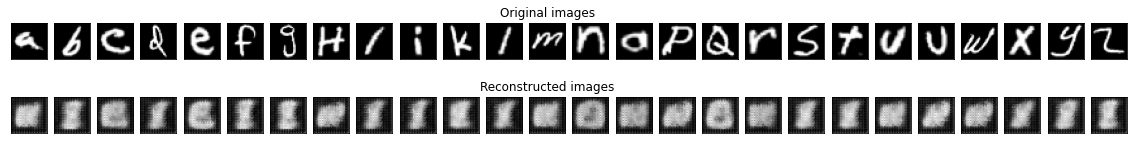

 20%|████████████████▍                                                                 | 10/50 [02:39<10:50, 16.25s/it]


 EPOCH 11/50 	 train loss 41.481 	 val loss 41.599


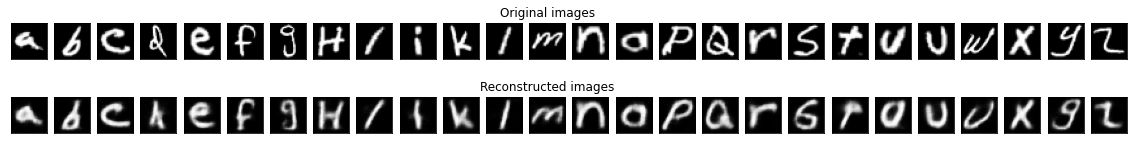

 40%|████████████████████████████████▊                                                 | 20/50 [05:17<07:34, 15.16s/it]


 EPOCH 21/50 	 train loss 40.558 	 val loss 40.554


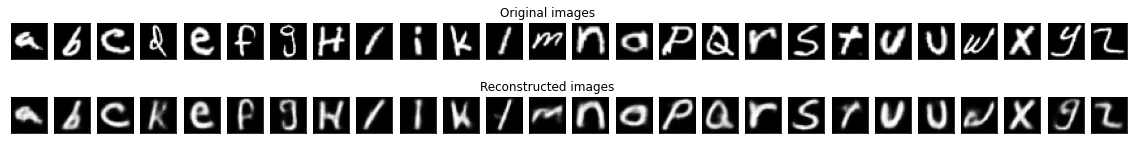

 60%|█████████████████████████████████████████████████▏                                | 30/50 [07:54<05:16, 15.81s/it]


 EPOCH 31/50 	 train loss 40.079 	 val loss 40.110


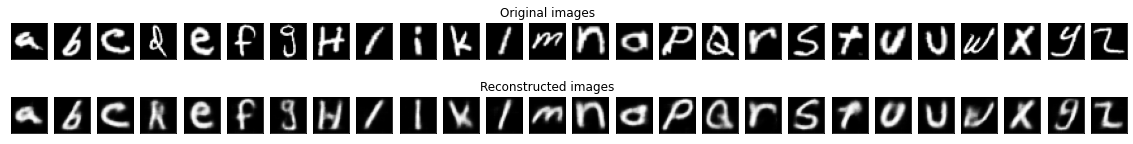

 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [10:32<02:34, 15.44s/it]


 EPOCH 41/50 	 train loss 39.793 	 val loss 39.850


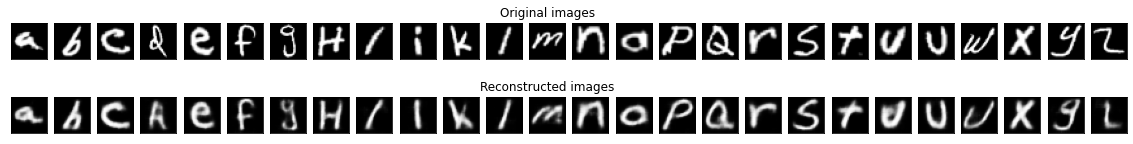

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [13:13<00:00, 15.87s/it]


In [190]:
num_epochs = 50
log_interval = 10

for epoch in tqdm(range(num_epochs)):
    train_loss = train_epoch(vae,device,train_loader,optim)
    val_loss = test_epoch(vae,device,valid_loader)
    if epoch % log_interval == 0:
        print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
        plot_ae_outputs(vae.encoder,vae.decoder,n=26)

**Visualize Result**

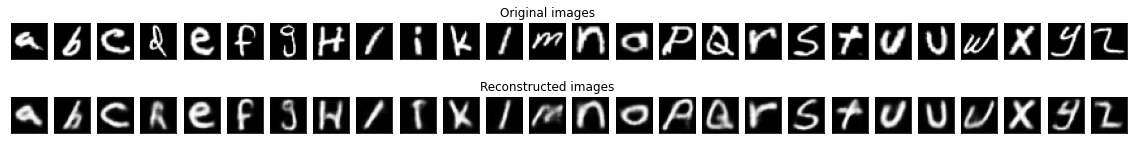

In [192]:
plot_ae_outputs(vae.encoder,vae.decoder,n=26)

As we can see, the VAE to some extent learned how to encode an originally 28 by 28 (784 d) image down to 2% of its original dimension (16 d). While it is imperfect (fuzzy 'd', 'j', 'v', 'w'), I think the result is very promising.

### Part 2: Generative Adversarial Networks

**Dataset**

For simplicity, all images are upscaled from 28 x 28 to 64 x 64.

In [12]:
data_dir = 'dataset'

train_dataset = torchvision.datasets.EMNIST(data_dir, 'letters', train=True, download=True)
test_dataset  = torchvision.datasets.EMNIST(data_dir, 'letters', train=False, download=True)

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
    transforms.Normalize(mean=0.5, std=0.5)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
    transforms.Normalize(mean=0.5, std=0.5)
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=128

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

**Model**

I am implementing the exact same model described in the original [DCGANs paper](https://arxiv.org/abs/1511.06434).

In [14]:
class Generator(nn.Module):
    '''
    Generate sample image using a randomly generated latent vector
    Input: N x latent_d x 1 x 1 (latend_d = 64)
    Output: N x C x H x W (1 x 1 x 28 in this case, same dimension as the EMNIST dataset)
    '''
    def __init__(self, latent_d, img_c, feat = 64):
        super(Generator, self).__init__()
        self.latent_d = latent_d
        self.img_c = img_c
        self.feat = feat
        # model definition
        self.net = nn.Sequential(
            # N x 64 x 1 x 1
            self.unpool(self.latent_d, self.latent_d * 16, kernel = 4, stride = 1, padding = 0),
            # N x 1024 x 4 x 4
            self.unpool(self.latent_d * 16, self.latent_d * 8, kernel = 4, stride = 2, padding = 1),
            # N x 512 x 8 x 8
            self.unpool(self.latent_d * 8, self.latent_d * 4, kernel = 4, stride = 2, padding = 1),
            # N x 256 x 16 x 16
            self.unpool(self.latent_d * 4, self.latent_d * 2, kernel = 4, stride = 2, padding = 1),
            # N x 128 x 32 x 32
            # last layer, no batchnorm needed
            nn.ConvTranspose2d(self.latent_d * 2, img_c, kernel_size = 4, stride = 2, padding = 1),
            # N x img_c x 64 x 64
            nn.Tanh()
        )

    def unpool(self, in_d, out_d, kernel, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels = in_d, out_channels = out_d, kernel_size = kernel, stride = stride, padding = padding, bias = False), # bias is not needed if batchnorm is used
            nn.BatchNorm2d(out_d),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.net(x)

class Discriminator(nn.Module):
    '''
    Binary classifier to determine whether given image is real or fake
    Input: N x 64 x 3 x 3
    Output: N x P (probabiltiy of True)
    '''
    def __init__(self, img_c, feat = 64):
        super(Discriminator, self).__init__()
        self.img_c = img_c
        self.feat = feat
        # model definition
        self.net = nn.Sequential(
            # first layer does not uses bnorm
            # N x 64 x 3 x 3
            nn.Conv2d(self.img_c, self.feat, kernel_size = 4, stride = 2, padding = 1),
            nn.LeakyReLU(0.2),
            # N x 32 x 32 x 128
            self.pool(self.feat, self.feat * 2, kernel = 4, stride = 2, padding = 1),
            # N x 16 x 16 x 256
            self.pool(self.feat * 2, self.feat * 4, kernel = 4, stride = 2, padding = 1),
            # N x 8 x 8 x 512
            self.pool(self.feat * 4, self.feat * 8, kernel = 4, stride = 2, padding = 1),
            # N x 4 x 4 x 1024
            # last layer does not uses bnorm
            nn.Conv2d(self.feat * 8, 1, kernel_size = 4, stride = 2, padding = 0),
            nn.Sigmoid() # binary classification
        )
    
    def pool(self, in_d, out_d, kernel, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels = in_d, out_channels = out_d, kernel_size = kernel, stride = stride, padding = padding, bias = False),
            nn.BatchNorm2d(out_d),
            nn.LeakyReLU(0.2)
        )
    
    def forward(self, x):
        return self.net(x)

**Training**

Hyperparameters

In [15]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [16]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

epochs = 10
learning_rate = 0.0002
feat = 64
latent_d = 100
img_c = 1

# models
netG = Generator(latent_d = 100, img_c = img_c, feat = feat).to(device)
netD = Discriminator(img_c = img_c, feat = feat).to(device)
initialize_weights(netG)
initialize_weights(netD)
netG.train()
netD.train()

# optimizers
opt_g = optim.Adam(netG.parameters(), lr = learning_rate, betas=(0.5, 0.999))
opt_d = optim.Adam(netD.parameters(), lr = learning_rate, betas=(0.5, 0.999))

# random noise
fixed_noise = torch.randn(32, latent_d, 1, 1).to(device)

cuda:0


Training loop

Training Epoch 0


780it [14:05,  1.08s/it]


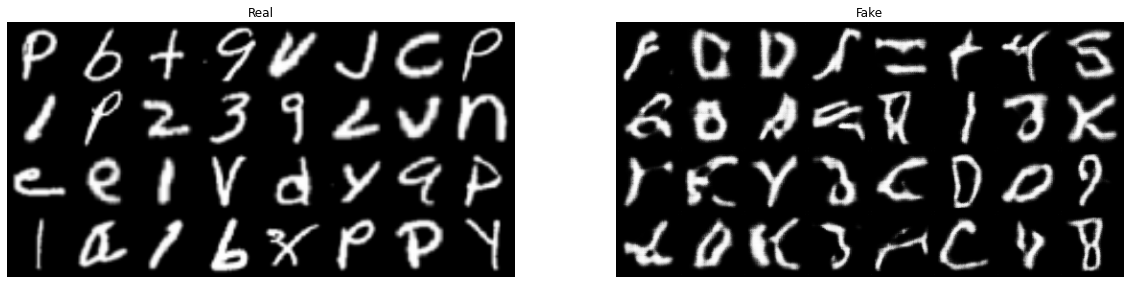

Epoch 0, train loss: 11.430244655595743
Training Epoch 1


780it [14:02,  1.08s/it]


Epoch 1, train loss: 9.956424234434962
Training Epoch 2


780it [14:00,  1.08s/it]


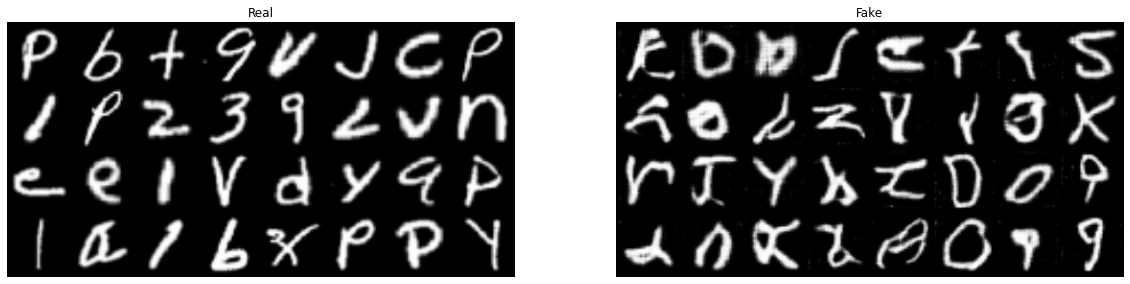

Epoch 2, train loss: 13.47798400616739
Training Epoch 3


780it [14:00,  1.08s/it]


Epoch 3, train loss: 16.624081444228068
Training Epoch 4


780it [14:00,  1.08s/it]


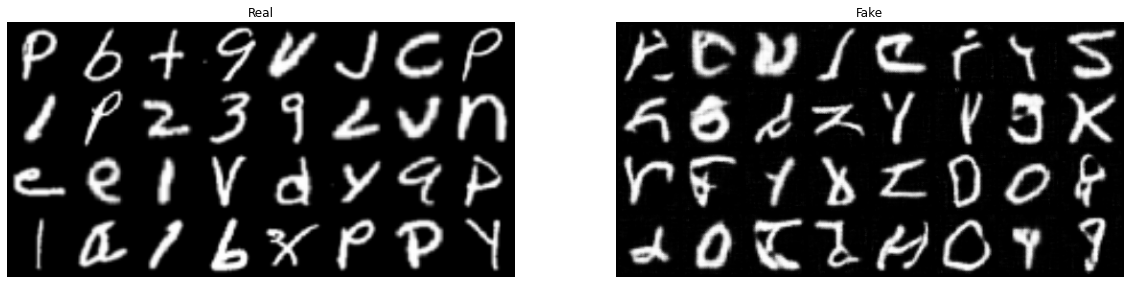

Epoch 4, train loss: 17.994635062059388
Training Epoch 5


780it [14:00,  1.08s/it]


Epoch 5, train loss: 19.492108757185633
Training Epoch 6


780it [13:59,  1.08s/it]


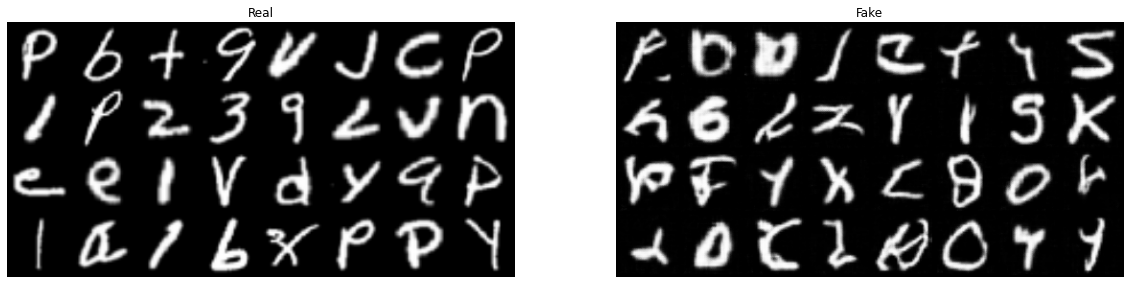

Epoch 6, train loss: 20.688937027123757
Training Epoch 7


780it [14:00,  1.08s/it]


Epoch 7, train loss: 21.2652695157376
Training Epoch 8


780it [14:00,  1.08s/it]


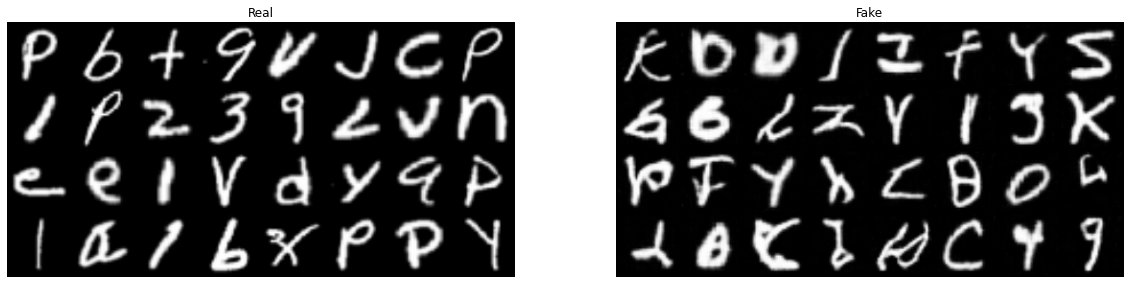

Epoch 8, train loss: 21.504722659432446
Training Epoch 9


780it [14:00,  1.08s/it]

Epoch 9, train loss: 22.36416621236276


In [17]:
for e in range(epochs):
    sum_loss = 0
    print(f'Training Epoch {e}')
    for idx, (real, _) in tqdm(enumerate(train_loader)):
        # send batch to device
        real = real.to(device)

        # generate random noise
        noise = torch.randn(batch_size, latent_d, 1, 1).to(device)
        fake = netG(noise)
        
        # train discriminator on real
        d_real = netD(real).squeeze(-1)
        # compute loss
        d_loss_real = F.binary_cross_entropy(d_real, torch.ones_like(d_real))
        
        # train discriminator on fake
        d_fake = netD(fake.detach()).squeeze(-1)
        # compute loss
        d_loss_fake = F.binary_cross_entropy(d_fake, torch.zeros_like(d_fake))
        
        # compute total loss for discriminator
        d_loss = (d_loss_real + d_loss_fake) / 2
        
        # zero out gradient and backprop
        netD.zero_grad()
        d_loss.backward()
        sum_loss += d_loss.item()
        opt_d.step()
        
        # train generator
        g_out = netD(fake).squeeze(-1)
        g_loss = F.binary_cross_entropy(g_out, torch.ones_like(g_out))
        
        # zero out gradient and backprop
        netG.zero_grad()
        g_loss.backward()
        sum_loss += g_loss.item()
        opt_g.step()
    
    if e % 2 == 0:
        with torch.no_grad():
            fake = netG(fixed_noise)
            # take out (up to) 32 examples
            img_grid_real = torchvision.utils.make_grid(
                real[:32], normalize=True, nrow = 4
            )
            img_grid_fake = torchvision.utils.make_grid(
                fake[:32], normalize=True, nrow = 4
            )
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,8))
            ax1.imshow(np.swapaxes((img_grid_real.detach().cpu().numpy() * 255).astype(np.uint8), 0, 2))
            ax1.set_title('Real')
            ax1.set_axis_off()
            ax2.imshow(np.swapaxes((img_grid_fake.detach().cpu().numpy() * 255).astype(np.uint8), 0, 2))
            ax2.set_title('Fake')
            ax2.set_axis_off()
            plt.show()
    
    # summary stats
    print(f'Epoch {e}, train loss: {sum_loss / batch_size}')

**Visualize Result**

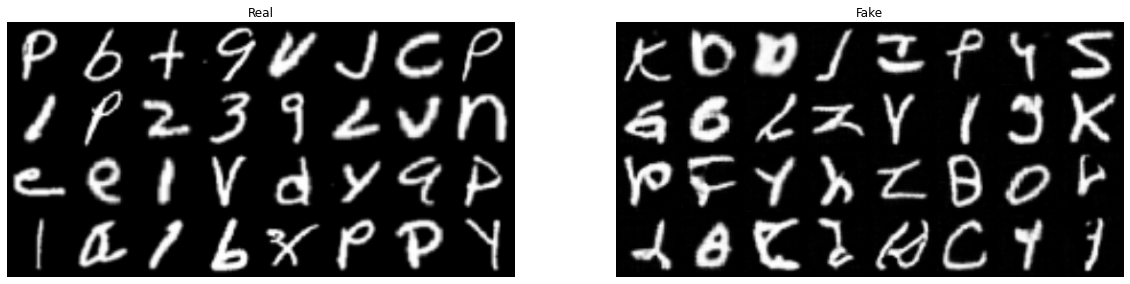

In [43]:
with torch.no_grad():
    fake = netG(fixed_noise)
    # take out (up to) 32 examples
    img_grid_real = torchvision.utils.make_grid(
        real[:32], normalize=True, nrow = 4
    )
    img_grid_fake = torchvision.utils.make_grid(
        fake[:32], normalize=True, nrow = 4
    )
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,8))
    ax1.imshow(np.swapaxes((img_grid_real.detach().cpu().numpy() * 255).astype(np.uint8), 0, 2))
    ax1.set_title('Real')
    ax1.set_axis_off()
    ax2.imshow(np.swapaxes((img_grid_fake.detach().cpu().numpy() * 255).astype(np.uint8), 0, 2))
    ax2.set_title('Fake')
    ax2.set_axis_off()
    plt.show()

Our GANs was able to generate new handwritten alphabets that looks similar enough to fool a human being. Although some digits are still kind of fuzzy (top left images), you can barely tell if the images in the middle is generated by a computer or an actual person, and this model have only been trained for 10 epochs due to time constraint. 

Here are some more generated examples:

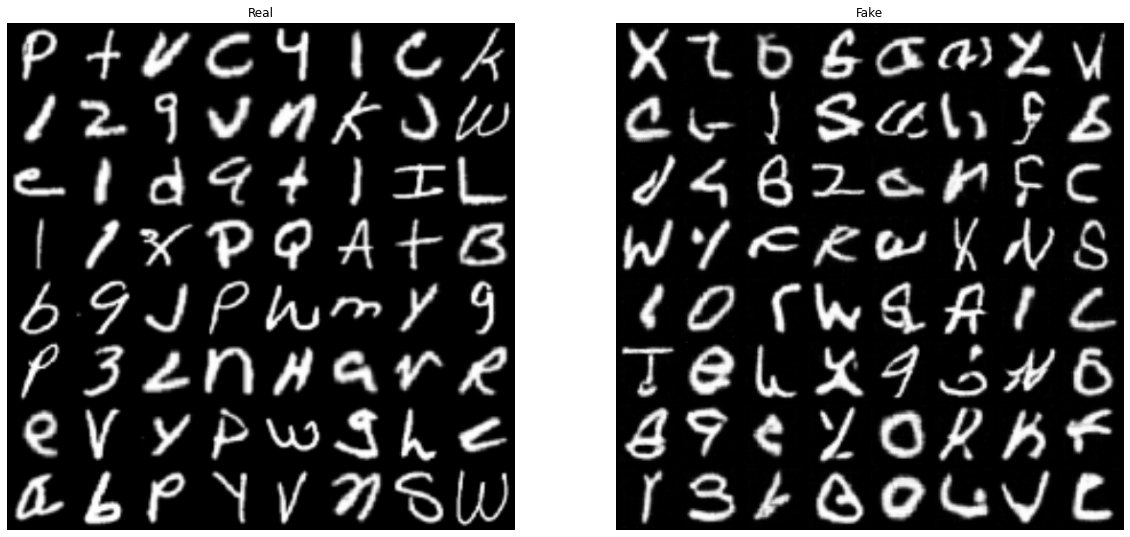

In [42]:
with torch.no_grad():
    fake = netG(torch.randn(64, latent_d, 1, 1).to(device))
    # take out (up to) 32 examples
    img_grid_real = torchvision.utils.make_grid(
        real[:64], normalize=True, nrow = 8
    )
    img_grid_fake = torchvision.utils.make_grid(
        fake[:64], normalize=True, nrow = 8
    )
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,10))
    ax1.imshow(np.swapaxes((img_grid_real.detach().cpu().numpy() * 255).astype(np.uint8), 0, 2))
    ax1.set_title('Real')
    ax1.set_axis_off()
    ax2.imshow(np.swapaxes((img_grid_fake.detach().cpu().numpy() * 255).astype(np.uint8), 0, 2))
    ax2.set_title('Fake')
    ax2.set_axis_off()
    plt.show()